In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

sns.set(style="whitegrid")


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Transactions.csv to Transactions.csv
Saving Products.csv to Products.csv
Saving Customers.csv to Customers.csv


In [ ]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")


In [ ]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

df = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Signup duration
max_date = df['TransactionDate'].max()
customers['SignupDays'] = (max_date - customers['SignupDate']).dt.days

# Aggregated behavioral data
agg = df.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),
    NumTransactions=('TransactionID', 'nunique'),
    AvgOrderValue=('TotalValue', 'mean')
).reset_index()

# Category frequency
category_pivot = pd.crosstab(df['CustomerID'], df['Category'])

# Combine
features = customers[['CustomerID', 'Region', 'SignupDays']]\
           .merge(agg, on='CustomerID')\
           .merge(category_pivot, on='CustomerID', how='left')
features = pd.get_dummies(features, columns=['Region'])

customer_ids = features['CustomerID']
X = features.drop(columns=['CustomerID'])


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


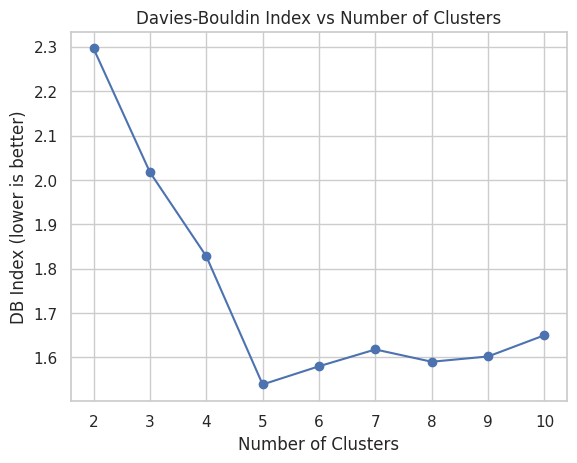

In [ ]:
db_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    db_index = davies_bouldin_score(X_scaled, labels)
    db_scores.append(db_index)

# Plot
plt.plot(cluster_range, db_scores, marker='o')
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index (lower is better)")
plt.show()


In [ ]:
best_k = cluster_range[np.argmin(db_scores)]
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

features['Cluster'] = cluster_labels


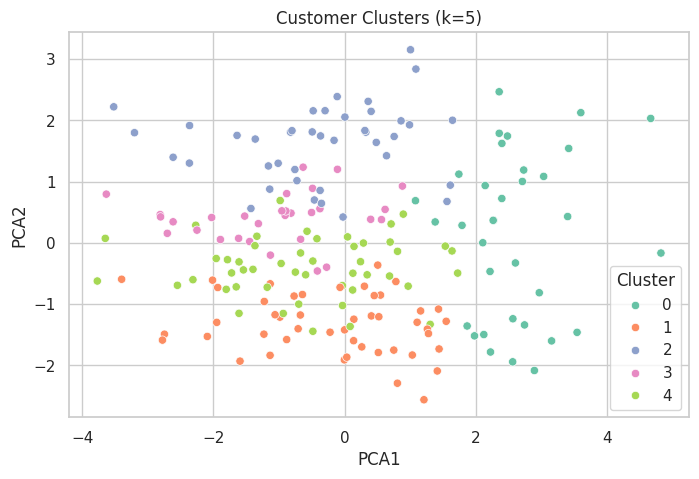

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
features['PCA1'] = pca_result[:, 0]
features['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8, 5))
sns.scatterplot(data=features, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title(f"Customer Clusters (k={best_k})")
plt.show()


In [ ]:
features[['CustomerID', 'Cluster']].to_csv("Customer_Clusters.csv", index=False)
files.download("Customer_Clusters.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>